# XOR

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from matplotlib import animation, rc, rcParams
from IPython.display import HTML
from matplotlib import colors

## Data

Both, training and testing sets consist of points uniformly distibutted across [-1, 1]x[-1, 1] square. Each point is either red or blue, depending in which quadrant is it placed. Points in 1st and 3rd quadrants are blue, points in 2nd and 4th quadrants are red.

In [15]:
torch.manual_seed(1)
np.random.seed(1)

In [34]:
train_sample_size = 256
X_train = np.random.uniform(-1, 1, size=(train_sample_size, 2))
Y_train = (X_train[:,0]*X_train[:,1] < 0).astype(np.float_)

In [35]:
test_sample_size = 128
X_test = np.random.uniform(-1, 1, size=(test_sample_size, 2))
Y_test = (X_test[:,0]*X_test[:,1] < 0).astype(np.float_)

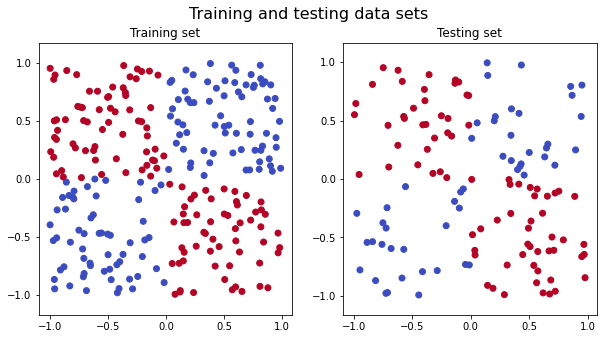

In [36]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle(f'Training and testing data sets', fontsize=16)

axs[0].scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap="coolwarm")
axs[0].set_title('Training set')
axs[0].axis('equal')

axs[1].scatter(X_test[:,0], X_test[:,1], c=Y_test, cmap="coolwarm")
axs[1].set_title('Testing set')
axs[1].axis('equal')

# plt.savefig(f'results/xor/xor_data.png')
plt.show()

In [37]:
x_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(Y_train).float()

x_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(Y_test).float()

## Net
### Structure

In [38]:
def def_net(layers, activation="ReLU", lr=0.05, seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    modules = []
    
    if activation=="ReLU":
        func = torch.nn.ReLU()
    elif activation=="Sigmoid":
        func = torch.nn.Sigmoid()
    else:
        raise Exception("Wrong activation function.")
    
    for i in range(len(layers)-2):
        modules.append(torch.nn.Linear(layers[i], layers[i+1]))
        modules.append(func)
    modules.append(torch.nn.Linear(layers[-2], layers[-1]))
    
    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.normal_(m.weight, std=0.05)
            torch.nn.init.normal_(m.bias, std=0.05)
    
    global net, learning_rate, activation_func, loss, optimizer, neurons
    net = torch.nn.Sequential(*modules)
    neurons = layers
    learning_rate = lr
    activation_func = activation
    loss = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
    net.apply(init_weights)

In [51]:
def_net(layers=[2, 3, 2], activation="ReLU", lr=0.01)

### Learning process

In [52]:
num_iter = 512
batch_size = 8

losses = []
train_errors = []
test_errors = []

X, Y = np.meshgrid(np.linspace(-1, 1, 128), np.linspace(-1, 1, 128))
color_norm=colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
frames = []

for epoch in tqdm.tqdm(range(num_iter)):
    losses_iter = []
    train_errors_iter = []
    test_errors_iter = []
    
    y_hat = net(x_test)
    test_errors += [(y_test != y_hat.argmax(1)).float().mean().item()]
    
    y_hat = net(x_train)
    train_errors += [(y_train != y_hat.argmax(1)).float().mean().item()]
    
    for batch in range(train_sample_size//batch_size):
        x_batch = x_train[batch*batch_size:(batch+1)*batch_size]
        y_batch = y_train[batch*batch_size:(batch+1)*batch_size]
        
        y_hat = net(x_batch)
        l = loss(y_hat, y_batch.type(torch.LongTensor))
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    Z = torch.nn.Softmax(dim=2)(net(torch.as_tensor(
        np.column_stack((X.reshape(-1), Y.reshape(-1))).reshape(128, 128, 2),
        dtype=torch.float32
    )))[:,:,0].detach().numpy()
    frames+=[Z]
      
    losses += [np.mean(losses_iter)]

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 86.53it/s]


## Results visualisation
### Summary

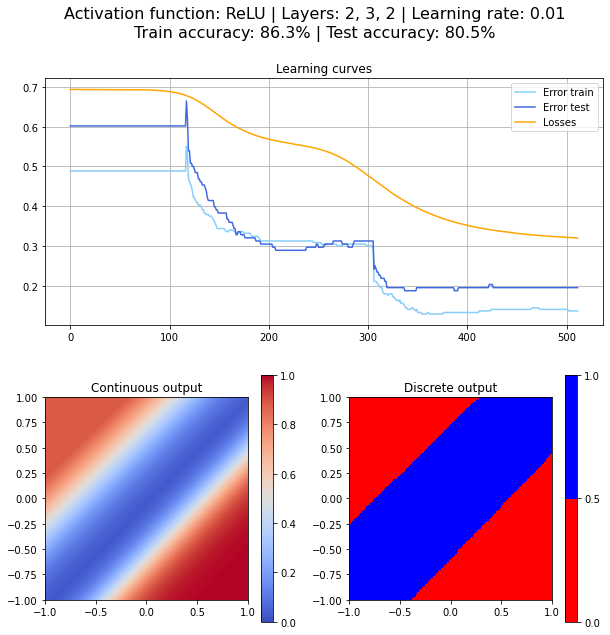

In [53]:
X, Y = np.meshgrid(np.linspace(-1, 1, 128), np.linspace(-1, 1, 128))

Z = torch.nn.Softmax(dim=2)(net(torch.as_tensor(
        np.column_stack((X.reshape(-1), Y.reshape(-1))).reshape(128, 128, 2),
        dtype=torch.float32
    )))[:,:,0].detach().numpy()

Z_discrete = (Z < 0.5)

fig = plt.figure(figsize=(10, 10))
# ttime = 'Learning results after {num_iter:3} epochs'
tdesc = f'Activation function: {activation_func} | Layers: {str(neurons)[1:-1]} | Learning rate: {learning_rate:1.3}'
tstat = f'\nTrain accuracy: {1-train_errors[-1]:2.1%} | Test accuracy: {1-test_errors[-1]:2.1%}'
fig.suptitle(tdesc+tstat,
             fontsize=16
            )
grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)

ax_curves = fig.add_subplot(grid[0, :])
ax_curves.plot(range(num_iter), train_errors, color='lightskyblue')
ax_curves.plot(range(num_iter), test_errors, color='royalblue')
ax_curves.plot(range(num_iter), losses, color='orange')
ax_curves.set_title("Learning curves")
ax_curves.legend(["Error train", "Error test", "Losses"])
ax_curves.grid()

c_norm=colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
ax1 = fig.add_subplot(grid[1, 0])
im1 = ax1.imshow(Z, extent=[-1, 1, -1, 1], cmap='coolwarm', norm=c_norm) # seismic coolwarm bwr RdBu
ax1.axis('image')
ax1.set_title('Continuous output')
fig.colorbar(im1, ax=ax1)

colormap = colors.ListedColormap(['red', 'blue'])
bounds=[0.,0.5,1.]
d_norm = colors.BoundaryNorm(bounds, colormap.N)
ax2 = fig.add_subplot(grid[1, 1])
im2 = ax2.imshow(Z_discrete, extent=[-1, 1, -1, 1], interpolation='nearest', cmap=colormap, norm=d_norm)
ax2.axis('image')
ax2.set_title('Discrete output')
fig.colorbar(im2, boundaries=bounds, ticks=[0., 0.5, 1.], ax=ax2)

# plt.savefig(f'results/xor/{activation_func + str(neurons)[1:-1:3] + "lr" + str(learning_rate)[2:]}.png')
plt.show()

### Learning process

In [12]:
rcParams['animation.embed_limit'] = 2**128

fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)
txt_title = fig.suptitle('', fontsize=16)

c_norm=colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
ax1 = fig.add_subplot(grid[0, 0])
im1 = ax1.imshow(frames[0], extent=[-1, 1, -1, 1], animated=True, cmap='coolwarm', norm=c_norm)
ax1.set_title('Continuous output')
fig.colorbar(im1, ax=ax1)

colormap = colors.ListedColormap(['red', 'blue'])
bounds=[0.,0.5,1.]
d_norm = colors.BoundaryNorm(bounds, colormap.N)
ax2 = fig.add_subplot(grid[0, 1])
im2 = ax2.imshow((frames[0] < 0.5), extent=[-1, 1, -1, 1], interpolation='nearest', cmap=colormap, norm=d_norm)
ax2.set_title('Discrete output')
fig.colorbar(im2, boundaries=bounds, ticks=[0., 0.5, 1.], ax=ax2)

ax_curves = fig.add_subplot(grid[1, :])
ax_curves.plot(range(num_iter), train_errors, color='lightskyblue')
ax_curves.plot(range(num_iter), test_errors, color='royalblue')
ax_curves.plot(range(num_iter), losses, color='orange')
epoch_line = ax_curves.axvline(x = 0, color = 'red')
ax_curves.set_title("Learning curves")
ax_curves.legend(["Error train", "Error test", "Losses"])
ax_curves.grid()

def animate(i):
    im1.set_array(frames[i])
    im2.set_array(frames[i] < 0.5)
    epoch_line.set_xdata(i)
    txt_title.set_text(f"Epoch: {i:3} | Train accuracy: {1-train_errors[i]:2.1%} | Test accuracy: {1-test_errors[i]:2.1%}")
    return im1, im2, epoch_line

anim = animation.FuncAnimation(fig, animate, frames=num_iter, interval=50, blit=True)
plt.close(fig)

# anim.save(f'results/gifs/{activation_func + str(neurons)[1:-1:3] + "lr" + str(learning_rate)[2]}.gif',
#           writer=animation.PillowWriter(fps=30))
HTML(anim.to_jshtml())